In [1]:
# Activate virtual envoriment:

import os
path='/work/scripts' # Remember to change kernel to virt_env!!!
os.chdir(path)
!./activate.sh 

./activate.sh: line 1: /work/807122/virt_env/bin/activate: No such file or directory
Installed kernelspec virt_env in /home/ucloud/.local/share/jupyter/kernels/virt_env
Done! Remember changing the kernel in Jupyter.


In [ ]:
### Check that im are in the right environment

import sys
print(sys.executable)
import nilearn

In [ ]:
# importing modules
import os
import pip
import numpy as np
import mne
import pickle
import itertools

import matplotlib.pyplot as plt
import importlib
importlib.reload(plt)

import pylab, seaborn as sns
from scipy.stats import ttest_rel, sem

%matplotlib inline 

from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D, BatchNormalization, SpatialDropout2D, Input, Flatten
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from keras.layers import LeakyReLU
from keras import regularizers

from sklearn.model_selection import ShuffleSplit, train_test_split, StratifiedKFold, StratifiedGroupKFold
from sklearn.model_selection import GridSearchCV, LeaveOneOut, LeaveOneGroupOut
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score, make_scorer, accuracy_score
from sklearn.utils import shuffle

from scipy.stats import binom_test, binomtest

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import matplotlib as mpl

from collections import Counter

import imblearn
from imblearn.over_sampling import RandomOverSampler

from scikeras.wrappers import KerasClassifier

from math import floor

import shap

# 1. Load data

In [ ]:
# Load data in with a hierarchical structure: each participants and respectively, their three sessions

data_dir = '/work/data/ds003626-download/derivatives/'

# Empty folder 
all_data = []

# Listing all folders in data_dir that start with "sub-"
participants = [folder for folder in os.listdir(data_dir) if folder.startswith('sub-')]

# Define a list of modality labels (i.e., trial class)
modality_label = ['Arriba', 'Abajo', 'Derecha', 'Izquierda']

# Create lists, that will be filled up with all participants' data
participants_pronounced = []
participants_inner = []
participants_visualized = []

# Loop through each participant's data
for participant in participants:
    participant_dir = os.path.join(data_dir, participant)
    
    # Create empty lists to store participant and session data (these resets for each participants)
    session_pronounced = []
    session_inner = []
    session_visualized = []
    
    # Loop through all sessions for each participant in part_dir
    for session_num in range(1, 4):  #session "ses-01", "ses-02", and "ses-03"
        session_dir = os.path.join(participant_dir, f'ses-0{session_num}')
        
        # [] = list, {} = dictonary 
        event_dat = []
        event_data = {}
        event_data_session = {}
        
        # Create dictionaries for the three conditions
        pronounced_con = {} # column 2 == 0
        inner_con = {} # column 2 == 1
        visualized_con = {} # column 2 == 2
        
        # .dat file path
        dat_file_path = os.path.join(session_dir, f'{participant}_ses-0{session_num}_events.dat')
    
       # if os.path.exists(dat_file_path):
        ## i have commented this line of code out, as I want to recieve an error if a event.dat file is missing
        with open(dat_file_path, "rb") as file: # "rb" = read in binary format
            event_dat = pickle.load(file)
       
        # loop over the elements of the modality_label list (match labels and events.dat)
        # filter the event_dat based on the values of column 2 (class/modality)
        for l, label in enumerate(modality_label):
            event_data[label] = event_dat[event_dat[:,1]==l,:] 
        
        # now event_data contains 4 arrays (one for each of the modalities)
 
        # EEG .fif file path
        eeg_file_path = os.path.join(session_dir, f'{participant}_ses-0{session_num}_eeg-epo.fif')
        
        #if os.path.exists(eeg_file_path):
        ## same goes for the eeg.fif files
        epochs = mne.read_epochs(eeg_file_path, preload=True)
        
        # Check for epochs .fif and events .dat file correspondence (they will be matched on timestamps)
        # Correspondence = 0
        if not sum(epochs.events[:,0]-event_dat[:,0])==0:
            print("MISMATCH IN EPOCHS/DAT FILE TIMESTAMPS! {}".format(session_dir))
            break # Naturally, we want to stop the loop, if an error / mismatch occurs 
        
        # Specify channel location (EEG data acquired used BioSemi128)
        montage = mne.channels.make_standard_montage('biosemi128')
        epochs.set_montage(montage, verbose=False)
        
        # Loop over each condition (0, 1, 2) in modaility_label in data-file
        for label in modality_label:
            pronounced_con[label] = epochs[label][event_data[label][:, 2] == 0]
            inner_con[label] = epochs[label][event_data[label][:, 2] == 1]
            visualized_con[label] = epochs[label][event_data[label][:, 2] == 2]
        
            # Same sanity-check for the conditions and modalities
            if not (sum(pronounced_con[label].events[:,0]-event_data[label][event_data[label][:, 2] == 0, 0])==0 or 
                    sum(inner_con[label].events[:,0]-event_data[label][event_data[label][:, 2] == 1, 0])==0 or
                    sum(visualized_con[label].events[:,0]-event_data[label][event_data[label][:, 2] == 2, 0])==0):
                print("MISMATCH IN LABEL EPOCHS / LABEL DAT FILE TIMESTAMPS! {}: {}".format(session_dir, label))
                break
        
        session_pronounced.append(pronounced_con)
        session_inner.append(inner_con)
        session_visualized.append(visualized_con)
     
    # Empty dictionaries to store concatenated data for each condition
    concatenated_pronounced = {}
    concatenated_inner = {}
    concatenated_visualized = {}
    
    # Loop through the modality labels
    for label in modality_label:
        # Concatenate the sessions for the pronounced con
        pronounced_sessions = [sessions[label] for sessions in session_pronounced]
        concatenated_pronounced[label] = mne.concatenate_epochs(pronounced_sessions)

        # Concatenate the sessions for the inner con
        inner_sessions = [sessions[label] for sessions in session_inner]
        concatenated_inner[label] = mne.concatenate_epochs(inner_sessions)

        # Concatenate the sessions for the visualized 
        visualized_sessions = [sessions[label] for sessions in session_visualized]
        concatenated_visualized[label] = mne.concatenate_epochs(visualized_sessions)
    
    # Combine back into an epochs object with the four directions as conditions
    # ... now I will be able to analyze all 4 directions/labels over all 3 sessions for inner speech in the same object
    conc_pronounced = mne.concatenate_epochs([concatenated_pronounced[label] for label in modality_label])
    conc_inner = mne.concatenate_epochs([concatenated_inner[label] for label in modality_label])
    conc_visualized = mne.concatenate_epochs([concatenated_visualized[label] for label in modality_label])
    
    # Print length of participant_data to check if it's empty
    print(f"Participant {participant}: Number of sessions with EEG data: {len(concatenated_pronounced)}")
    
    # Append the EEG data to the participant_data list
    participants_pronounced.append(conc_pronounced)  
    participants_inner.append(conc_inner)  
    participants_visualized.append(conc_visualized)  
        
    # Append the epochs to the all_data list
    #all_data.append(epochs)
            
# Print length of all_data to check if it's empty 
print(f"Total number of participants with EEG data: {len(participants_pronounced)}")


### 1.2 Filtering

In [ ]:
low_pass = 40  # Lets all frequencies lower than 40 Hz pass through

# Loop through all participants' conditions and apply low-pass filter of 40 Hz
for i in range(0, 10):      
    participants_pronounced[i] = participants_pronounced[i].filter(None, low_pass)

for i in range(0, 10):      
    participants_inner[i] = participants_inner[i].filter(None, low_pass)

for i in range(0, 10):      
    participants_visualized[i] = participants_visualized[i].filter(None, low_pass)

### 1.3 Reject criteria + bad channels + Interpolate bad channels

In [5]:
# The following channels will be removed, as they caused too many epochs to be rejected:

participants_pronounced[1].info['bads'] = ['D24', 'D18', 'B4', 'B2', 'D9', 'D10', 'A5','D14', 'A30', 'D20', 'B24'] 
participants_inner[1].info['bads'] = ['D24', 'D18', 'B4', 'B2', 'D9', 'D10', 'A5', 'D14', 'A30', 'D20', 'B24'] 
participants_visualized[1].info['bads'] = ['D24', 'D18', 'B4', 'B2', 'D9', 'D10', 'A5'] 

participants_pronounced[2].info['bads'] = ['A25', 'A27']
participants_inner[2].info['bads'] = ['A25', 'A27']
participants_visualized[2].info['bads'] = ['A25', 'A27']

participants_pronounced[4].info['bads'] =['B23', 'B24']
participants_inner[4].info['bads'] =['B23', 'B24']
participants_visualized[4].info['bads'] =['B26']

participants_pronounced[5].info['bads'] =['D6', 'D8', 'D9', 'D10']
participants_inner[5].info['bads'] =['D6', 'D8', 'D9', 'D10']
participants_visualized[5].info['bads'] =['D6', 'D8', 'D9', 'D10']

participants_pronounced[9].info['bads'] = ['D1', 'C1', 'B20', 'A1', 'A2', 'A3', 'B1', 'C2']
participants_inner[9].info['bads'] = ['D1', 'C1', 'B20', 'A1', 'A2', 'A3', 'B1', 'C2']

In [ ]:
# Interpolate bad channels
# Before doing classification, it is important, that my data maintain identical dimensionalities for all subjects
# As the same channels are not bad for all subjects, I will reconstruct bad channels by interpolating its signal
# based on the signals of the good sensors around them

for sub in participants_pronounced:
    sub.copy().interpolate_bads(reset_bads=False)

for sub in participants_inner:
    sub.copy().interpolate_bads(reset_bads=False)

for sub in participants_visualized:
    sub.copy().interpolate_bads(reset_bads=False)

In [ ]:
# Rejecting EEG epochs above 200 microvolts.
reject_criteria = dict(eeg=200e-6)

# Loop through the list of EpochsArray objects for each participant in each condtion
for sub in participants_pronounced:
    sub.drop_bad(reject=reject_criteria)
    
for sub in participants_inner:
    sub.drop_bad(reject=reject_criteria)

for sub in participants_visualized:
    sub.drop_bad(reject=reject_criteria)

### 1.5 Time window for epochs

In [8]:
# Pronounced vs inner speech:
## I only want to classify signal from the action interval (where the participant had to imagine or pronounce speech),
## I have to define the temporal epoch, which I will use as input for the classifier.

action_participants_pronounced = []
action_participants_inner = []
action_participants_visualized = []

action_tmin = 1
action_tmax = 3.5

for sub in participants_pronounced:
    time_windowed_data = sub.copy().crop(tmin=action_tmin, tmax=action_tmax)
    action_participants_pronounced.append(time_windowed_data)

for sub in participants_inner:
    time_windowed_data = sub.copy().crop(tmin=action_tmin, tmax=action_tmax)
    action_participants_inner.append(time_windowed_data)

for sub in participants_visualized:
    time_windowed_data = sub.copy().crop(tmin=action_tmin, tmax=action_tmax)
    action_participants_visualized.append(time_windowed_data)

In [ ]:
# Rest vs inner speech:
## as the timestamps dont match, I apply numpy.concatenate directly on my numpy arrays
## No need to apply RandomOverSampler as this data is balanced

action_participants_inner_2 = []
rest_participants_inner = []

rest_tmin = 3.5
rest_tmax = 4

action_tmin_2 = 1
action_tmax_2 = 1.5

for sub in participants_inner:
    time_windowed_data = sub.copy().crop(tmin=action_tmin_2, tmax=action_tmax_2)
    action_participants_inner_2.append(time_windowed_data.get_data())

for sub in participants_inner:
    rest_time_window_data = sub.copy().crop(tmin=rest_tmin, tmax=rest_tmax)
    rest_participants_inner.append(rest_time_window_data.get_data())

ri_X = []
ri_y = []
    
for participant_idx in range(len(participants_inner)):
    X_rest = rest_participants_inner[participant_idx]
    X_action = action_participants_inner_2[participant_idx]
    
    y_rest = np.zeros(X_rest.shape[0])
    y_action = np.ones(X_action.shape[0])
    
    # Concatenate numpy arrays directly
    X_participant = np.concatenate([X_rest, X_action], axis=0)
    y_participant = np.concatenate([y_rest, y_action], axis=0)

    class_balanced = Counter(y_participant)
    print(f'Participant {participant_idx}: {class_balanced}')
    
    #info = participant.info  # Use the info from one of the original Epochs objects
    #epochs = EpochsArray(X_participant, info)

    ## Pick ROI ##
    #### Copy subsets from below and insert here!!!! ####
    #subset_left_hemisphere = ['C29', 'C28', 'C26', 'C24', 'C31', 'C32', 'D7', 'D5', 'D3', 'D13', 'D11', 'D23', 'D21', 'D19', 'D14',
    #                          'D24', 'D26', 'D28', 'D16', 'D31', 'D29', 'A6', 'A12', 'A10', 'A8', 'A14', 'A16', 'A18', 'C17', 'C19',
    #                          'C21', 'C23', 'A1', 'A3', 'A19', 'A21', 'A23', 'A25', 'D9']

    #epochs_subset = epochs.copy().pick_channels(subset_left_hemisphere)
    
    ri_X.append(X_participant) #epochs_subset.get.data()
    ri_y.append(y_participant)

ri_X_overall = np.vstack(ri_X) # (448, 128, 129)
ri_y_overall = np.hstack(ri_y) # (448,)

### 1.6 Channel selection

In [17]:
inner_ch_names = action_participants_inner[0].ch_names

print(len(inner_ch_names)) # Originally = 128 

128
128


In [ ]:
left_participant_pronounced = []
left_participant_inner = []

for participant_pronounced, participant_inner in zip(action_participants_pronounced, action_participants_inner):
    # Subset: Left Hemisphere
    subset_left_hemisphere = ['C29', 'C28', 'C26', 'C24', 'C31', 'C32', 'D7', 'D5', 'D3', 'D13', 'D11', 'D23', 'D21', 'D19', 'D14',
                              'D24', 'D26', 'D28', 'D16', 'D31', 'D29', 'A6', 'A12', 'A10', 'A8', 'A14', 'A16', 'A18', 'C17', 'C19',
                              'C21', 'C23', 'A1', 'A3', 'A19', 'A21', 'A23', 'A25', 'D9']

    left_p_ch_names = [x for x in participant_pronounced.ch_names if x in subset_left_hemisphere]
    left_i_ch_names = [x for x in participant_inner.ch_names if x in subset_left_hemisphere]

    left_sub_pron = participant_pronounced.copy().pick_channels(left_p_ch_names)
    left_sub_inner = participant_inner.copy().pick_channels(left_i_ch_names)

    left_participant_pronounced.append(left_sub_pron) 
    left_participant_inner.append(left_sub_inner)

# 39 channels

In [ ]:
bw_participant_pronounced = []
bw_participant_inner = []

for participant_pronounced, participant_inner in zip(action_participants_pronounced, action_participants_inner):
    # Subset: Broca-Wernicke
    subset_broca_wernicke = ['D7', 'D6', 'D5', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D23', 'D22', 'D21', 'D20',
                             'D19', 'D18', 'D14', 'D15', 'D24', 'D25','D26', 'D27', 'D28', 'D17', 'D16', 'D32', 'D31', 'D30', 'D29', 'A1']

    bw_pronounced_ch_names = [x for x in participant_pronounced.ch_names if x in subset_broca_wernicke]
    bw_inner_ch_names = [x for x in participant_inner.ch_names if x in subset_broca_wernicke]

    bw_sub_pronounced = participant_pronounced.copy().pick_channels(bw_pronounced_ch_names)
    bw_sub_inner = participant_inner.copy().pick_channels(bw_inner_ch_names)

    bw_participant_pronounced.append(bw_sub_pronounced)
    bw_participant_inner.append(bw_sub_inner)

# 29 channels

# 2. Model

In [9]:
def my_EEGNet_model(nb_classes, Chans, Samples, kernLength=128, F1=8, F2=16, D=2):
    
        input_layer = Input(shape=(Chans, Samples, 1))
        
        block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input_layer)
        block1 = BatchNormalization()(block1) 
        block1 = DepthwiseConv2D((Chans, 1), depth_multiplier=D, use_bias=False, depthwise_constraint = max_norm(1.))(block1)
        block1 = BatchNormalization()(block1)
        block1 = Activation('elu')(block1)
        block1 = AveragePooling2D((1, 8))(block1)
        block1 = Dropout(0.5)(block1)
        
        block2 = SeparableConv2D(F2, (1, 16), use_bias = False, padding = 'same')(block1)
        block2 = BatchNormalization()(block2)
        block2 = Activation('elu')(block2)
        block2 = AveragePooling2D((1, 16))(block2)
        block2 = Dropout(0.5)(block2)

        flatten = Flatten()(block2)

        dense = Dense(nb_classes, kernel_constraint = max_norm(0.25))(flatten)
        softmax = Activation('softmax')(dense)
            
        return Model(inputs=input_layer, outputs=softmax, name = 'my_EEGNet_model')

## 2.1 Binary

In [ ]:
###################################
######## Binary classifier #######
#### 5-fold cross validation ####
################################

save_path = '/work/SofieNørboMosegaard#5741/save_5f_EEGNet/'

# Initialize lists to store performance metrics for all participants
all_accuracies = []
all_losses = []
all_f1_scores = []
all_conf_matrices = []
all_true_labels = []
all_predicted_labels = []

# 5-fold cv
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=123)

# Initialize RobustScaler
scaler = RobustScaler()

for participant_idx in range(0, 10):
    print(f"Participant {participant_idx}")
    
    X = mne.concatenate_epochs([action_participants_pronounced[participant_idx], action_participants_inner[participant_idx]]).get_data()
    y = np.concatenate([np.zeros(len(action_participants_pronounced[participant_idx])), np.ones(len(action_participants_inner[participant_idx]))])
    
    participant_true = []
    participant_pred = []
    
    # Initialize model for each participant
    model = my_EEGNet_model(nb_classes=2, Chans=X.shape[1], Samples=X.shape[2], kernLength=128, F1=8, F2=16, D=2)
    #model.summary() 
  
    # Loop through the folds for cross-validation
    for fold_idx, (train_index, test_index) in enumerate(skf.split(X, y)):
        print(f"Fold: {fold_idx}")
        X_train, X_test = X[train_index], X[test_index] # (247, 128, 641), (62, 128, 641)
        Y_train, Y_test = y[train_index], y[test_index] # (247,), (62,)

        # Scale the data sets seperatly
        X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flattening to 2D before scaling the data, (247, 82048)
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
                
        X_train_scaled = scaler.fit_transform(X_train_flat)
        X_test_scaled = scaler.fit_transform(X_test_flat)

        X_train = X_train_scaled.reshape((-1, 128, 641, 1))
        X_test = X_test_scaled.reshape((-1, 128, 641, 1))

        print(X_train.shape) # (247, 128, 641, 1)
        print(X_test.shape) # (62, 128, 641, 1)
        
        # Now the data is NHWC (trials, channels, samples, kernels) format like Lawhern

        # Apply RandomOverSampler to the data sets seperatly
        ## OBS: For rest/inner, comment out the following lines of code as the data already is balanced
        class_train_before = Counter(Y_train)
        print(f'Participant {participant_idx}: {class_train_before}') # ({1.0: 163, 0.0: 84})

        oversample = RandomOverSampler(sampling_strategy='minority')

        X_train, Y_train = oversample.fit_resample(X_train.reshape(-1, 128 * 641), Y_train) 
        X_train = X_train.reshape((-1, 128, 641, 1))

        class_train_after = Counter(Y_train)
        print(f'Participant {participant_idx}: {class_train_after}') # ({0.0: 163, 1.0: 163})
    
        # Convert labels to one-hot encodings
        Y_train = keras.utils.to_categorical(Y_train, 2) # 2 = binær, 4 = multiclass
        Y_test = keras.utils.to_categorical(Y_test, 2)
        
        # Model compile
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Model training
        epochs = 50
        batch_size = 10
        
        # Model training
        callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)]
        
        fittedModel = model.fit(X_train, Y_train,
                                validation_data=(X_test, Y_test),
                                verbose=2,
                                epochs=epochs, batch_size=batch_size,
                                callbacks=callbacks)


        # Save the model for this fold
        #model_filename = os.path.join(save_path, f'participant_{participant_idx}_fold_{fold_idx}_model.h5')
        #model.save(model_filename)
        
        # Model evaluation
        score = model.evaluate(X_test, Y_test, verbose=0)
        print("Test loss:", score[0])
        print("Test accuracy:", score[1])
        
        all_accuracies.append(score[1])
        all_losses.append(score[0])
        
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)  
        y_true = np.argmax(Y_test, axis=1)
        
        # Append true and predicted values for each fold
        participant_true.extend(y_true)
        participant_pred.extend(y_pred_classes)
        
        # Plot model accuracy - Train and Validation
        plt.plot(fittedModel.history['accuracy'], label='Train Accuracy')
        plt.plot(fittedModel.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

        # Plot model loss - Train and Validation
        plt.plot(fittedModel.history['loss'], label='Train Loss')
        plt.plot(fittedModel.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_classes)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()
        
        all_conf_matrices.append(conf_matrix)
        
        # Calculate F1-score for the fold
        fold_f1 = f1_score(y_true, y_pred_classes, average='binary')
        all_f1_scores.append(fold_f1)
        print("Fold f1 score:", fold_f1)
        
        # Model evaluation
        score = model.evaluate(X_test, Y_test, verbose=0)
        print("Test loss:", score[0])
        print("Test accuracy:", score[1])
    
    # Calculate F1-score for the participant
    participant_f1 = f1_score(participant_true, participant_pred, average='binary')
    all_f1_scores.append(participant_f1)
    print("f1 score:", participant_f1)
    
    all_true_labels.extend(participant_true)
    all_predicted_labels.extend(participant_pred)
    
mean_accuracy = np.mean(all_accuracies)
std_accuracy = np.std(all_accuracies)
mean_loss = np.mean(all_losses)
std_loss = np.std(all_losses)

print(f"Mean Accuracy: {mean_accuracy}, Std Accuracy: {std_accuracy}")
print(f"Mean Loss: {mean_loss}, Std Loss: {std_loss}")

print(classification_report(participant_true, participant_pred, digits=3))

# The average confusion matrix
avg_conf_matrix = np.mean(all_conf_matrices, axis=0)
sns.heatmap(avg_conf_matrix, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix')
plt.show()


In [ ]:
# Significance and permutation test

num_permutations = 1000
permutation_scores = []
num_classes = 2

# Permutation loop
for _ in range(num_permutations):
    shuffled_labels = shuffle(all_predicted_labels)
    accuracy = accuracy_score(all_true_labels, shuffled_labels) # y_true, y_pred
    permutation_scores.append(accuracy)
    
p_value = (np.sum(np.array(permutation_scores) >= mean_accuracy) + 1) / (num_permutations + 1)
print(p_value)

plt.hist(permutation_scores, 20, label='Permutation scores', edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [mean_accuracy], ylim, '--g', linewidth=3, label=f'Actual Accuracy (p-value {p_value:.4f})')
plt.plot(2 * [1. / num_classes], ylim, '--k', linewidth=3, label='Chance level')
plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.title('Permutation Test for Accuracy')
plt.show()

In [ ]:
# SHAP - explain the binary CNN

# since we have 2 inputs (binary), we pass a list of inputs to the explainer
explainer = shap.GradientExplainer(model, X_train)

# explain the model's predictions on the first four samples of the test set
shap_values = explainer.shap_values(X_test[:4])

# since the model has 2 outputs we get a list of 2 explanations (one for each output)
print(len(shap_values))

# here we plot the explanations for all classes for the input (this is the feed forward input)
shap.image_plot([shap_values[i] for i in range(2)], X_test[:4])

## 2.1 Multiclass

In [ ]:
# Create X and y arrays + ensure that all modality labels are correct

modality_label = ['Arriba', 'Abajo', 'Derecha', 'Izquierda']
multi_X = []
multi_y = []

for participant_idx, participant in enumerate(action_participants_inner):
    X_participant = []
    y_participant = []
        
    for label in modality_label:
        data = participant[label]
        
        for trial_idx in range(len(data)):
            epoch_data = data[trial_idx].get_data()
            X_participant.append(epoch_data)
            label_index = modality_label.index(label)
            y_participant.append(label_index)

    X_participant = np.array(X_participant)
    y_participant = np.array(y_participant)

    class_before = Counter(y_participant)
    print(f'Participant {participant_idx}: {class_before}')

    X_participant = np.squeeze(X_participant) # To ensure shape (221, 128, 641)
    
    # For ROI selection
    #### Just copy subsets from above and insert here!!!! ####
    if len(set(y_participant)) > 1:

        # Create an MNE EpochsArray using the reshaped data
        #info = participant.info  # Use the info from one of the original Epochs objects
        #epochs = EpochsArray(X_participant, info)

        #subset_broca_wernicke = ['D7', 'D6', 'D5', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D23', 'D22', 'D21', 'D20',
        #                     'D19', 'D18', 'D14', 'D15', 'D24', 'D25','D26', 'D27', 'D28', 'D17', 'D16', 'D32', 'D31', 'D30', 'D29', 'A1']

        #epochs_subset = epochs.copy().pick_channels(subset_broca_wernicke)

        #multi_X.append(epochs_subset.get_data())
        #multi_y.append(y_participant)
    
    multi_X.append(X_participant) # Change to "epochs_subset.get_data()" when creating BA2 and BA3
    multi_y.append(y_participant)

multi_X_overall = np.vstack(multi_X) # (221, 128, 641)
multi_y_overall = np.hstack(multi_y) # (221,)

In [ ]:
#################################
####### MULTICLASS MODEL #######
### 5-fold cross validation ###
###############################

save_path = '/work/SofieNørboMosegaard#5741/save_5f_multi_EEGNet/'

# Initialize lists to store performance metrics for all participants
all_accuracies = []
all_losses = []
all_f1_scores = []
all_conf_matrices = []
all_true_labels = []
all_predicted_labels = []

# 5-fold cv
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=123)

scaler = RobustScaler()

for participant_idx in range(0, 10):
    print(f"Participant {participant_idx}")
    X = multi_X[participant_idx] # change to multi_X and multi_y for BA2 and BA3 testing
    y = multi_y[participant_idx]
    
    participant_true = []
    participant_pred = []
    
    # Initialize model for each participant
    model = my_EEGNet_model(nb_classes=4, Chans=X.shape[1], Samples=X.shape[2], kernLength=128, F1=8, F2=16, D=2)
    #model.summary() 

    # Loop through the folds for cross-validation
    for fold_idx, (train_index, test_index) in enumerate(skf.split(X, y)):
        print(f"Fold: {fold_idx}")
        X_train, X_test = X[train_index], X[test_index] # (163, 128, 641), (41, 128, 641)
        Y_train, Y_test = y[train_index], y[test_index] # (163,), (41,)
        
        X_train = X_train.reshape(X_train.shape[0], -1)  # Flattening to 2D before scaling the data
        X_test = X_test.reshape(X_test.shape[0], -1)
        
        # Apply data scaling using RobustScaler
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Reshape the data back to its original shape --> (163, 128, 641, 1)
        X_train = X_train_scaled.reshape((-1, 128, 641, 1)) ### REMEMBER TO CHANGE
        X_test = X_test_scaled.reshape((-1, 128, 641, 1))

        print(X_train.shape) # (163, 128, 641, 1)
        print(X_test.shape) # (41, 128, 641, 1)

        # Now the data is NHWC (trials, channels, samples, kernels) format like Lawhern

        # Apply RandomOverSampler to the training data
        class_train_before = Counter(Y_train)
        print(f'Participant {participant_idx}: {class_train_before}') # {2: 43, 1: 41, 3: 40, 0: 39}
                
        sampling_strategy = {cls: max(class_train_before.values()) for cls in np.unique(Y_train)}

        oversample = RandomOverSampler(sampling_strategy=sampling_strategy)

        X_train, Y_train = oversample.fit_resample(X_train.reshape(-1, 128 * 641), Y_train)
        X_train = X_train.reshape((-1, 128, 641, 1))

        class_after = Counter(Y_train)
        print(f'Participant {participant_idx} After: {class_after}') # {0: 43, 1: 43, 2: 43, 3: 43}

        # Convert labels to one-hot encodings
        Y_train = keras.utils.to_categorical(Y_train, 4) # 2 = binær, 4 = multiclass
        Y_test = keras.utils.to_categorical(Y_test, 4)
                
        # Model compile
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Model training
        epochs = 50
        batch_size = 10
        
        # Model training
        # OBS: skal monitor sættes til val_loss eller val_accuracy?
        callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)] # Skal patience hæves?
        
        fittedModel = model.fit(X_train, Y_train,
                                validation_data=(X_test, Y_test),
                                verbose=2,
                                epochs=epochs, batch_size=batch_size,
                               callbacks=callbacks)


        # Save the model for this fold
        model_filename = os.path.join(save_path, f'participant_{participant_idx}_fold_{fold_idx}_model.h5')
        model.save(model_filename)

        # Calculate and store accuracy and loss metrics
        accuracy = fittedModel.history['val_accuracy'][-1]
        loss = fittedModel.history['val_loss'][-1]
        all_accuracies.append(accuracy)
        all_losses.append(loss)
        
        # Plot model accuracy - Train and Validation (adjust data source and save plot if needed)
        plt.plot(fittedModel.history['accuracy'], label='Train Accuracy')
        plt.plot(fittedModel.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

        # Plot model loss - Train and Validation (adjust data source and save plot if needed)
        plt.plot(fittedModel.history['loss'], label='Train Loss')
        plt.plot(fittedModel.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

        # Model evaluation (adjust data source if needed)
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = np.argmax(Y_test, axis=1)

        # Append true and predicted values for each fold
        participant_true.extend(y_true)
        participant_pred.extend(y_pred_classes)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_classes)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()
        
        all_conf_matrices.append(conf_matrix)
        
        # Calculate F1-score for the fold
        fold_f1 = f1_score(y_true, y_pred_classes, average='weighted') 
        all_f1_scores.append(fold_f1)
        print("Fold f1 score:", fold_f1)

        # Model evaluation
        score = model.evaluate(X_test, Y_test, verbose=0)
        print("Test loss:", score[0])
        print("Test accuracy:", score[1])
    
    # Calculate F1-score for the participant
    participant_f1 = f1_score(participant_true, participant_pred, average='weighted')
    all_f1_scores.append(participant_f1)
    print("f1 score:", participant_f1)
    
    all_true_labels.extend(participant_true)
    all_predicted_labels.extend(participant_pred)
    
mean_accuracy = np.mean(all_accuracies)
std_accuracy = np.std(all_accuracies)
mean_loss = np.mean(all_losses)
std_loss = np.std(all_losses)

print(f"Mean Accuracy: {mean_accuracy}, Std Accuracy: {std_accuracy}")
print(f"Mean Loss: {mean_loss}, Std Loss: {std_loss}")

print(classification_report(participant_true, participant_pred, digits=3))

# The average confusion matrix
avg_conf_matrix = np.mean(all_conf_matrices, axis=0)
sns.heatmap(avg_conf_matrix, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix')
plot.show

In [ ]:
# Significance and permutation test

num_permutations = 1000
permutation_scores = []
num_classes = 4

# Permutation loop
for _ in range(num_permutations):
    shuffled_labels = shuffle(all_true_labels) # or all_predicted_labels?
    accuracy = accuracy_score(all_true_labels, shuffled_labels)
    permutation_scores.append(accuracy)

p_value = (np.sum(np.array(permutation_scores) >= mean_accuracy) + 1) / (num_permutations + 1)
print(p_value)

plt.hist(permutation_scores, 20, label='Permutation scores', edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [mean_accuracy], ylim, '--g', linewidth=3, label=f'Actual Accuracy (p-value {p_value:.4f})')
plt.plot(2 * [1. / num_classes], ylim, '--k', linewidth=3, label='Chance level')
plt.ylim(ylim)
plt.legend()
plt.xlabel('Accuracy')
plt.title('Permutation Test for Accuracy')
plt.show()

In [ ]:
# SHAP - explain the multiclass CNN

explainer = shap.GradientExplainer(model, X_train)
shap_values = explainer.shap_values(X_test[1:5]) # shap_values = list of 4 arrays (one for each class)
print(len(shap_values))
shap.image_plot([shap_values[i] for i in range(4)], X_test[1:5])

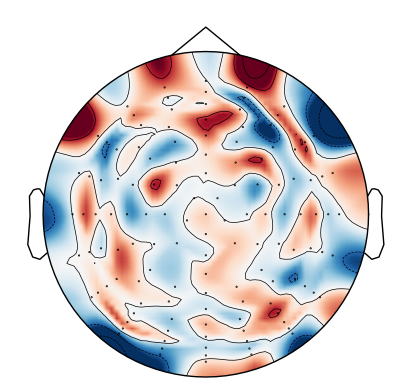

(<matplotlib.image.AxesImage at 0x7f89fb05a1a0>,
 <matplotlib.contour.QuadContourSet at 0x7f89fb05ab30>)

In [167]:
# Plot shap_values averaged across for all classes

shap_values_per_class = [np.mean(values, axis=2) for values in shap_values]  # Average 
shap_values_mean = np.mean(shap_values_per_class, axis=0)  # Average over classes
electrode_importance = shap_values_mean[0, :]
electrode_importance = electrode_importance.flatten() # make 1D (n_sensors, )
info = action_participants_inner[0].info # take mne info from one subject
mne.viz.plot_topomap(electrode_importance, info, show=True, ch_type='eeg', size=4)

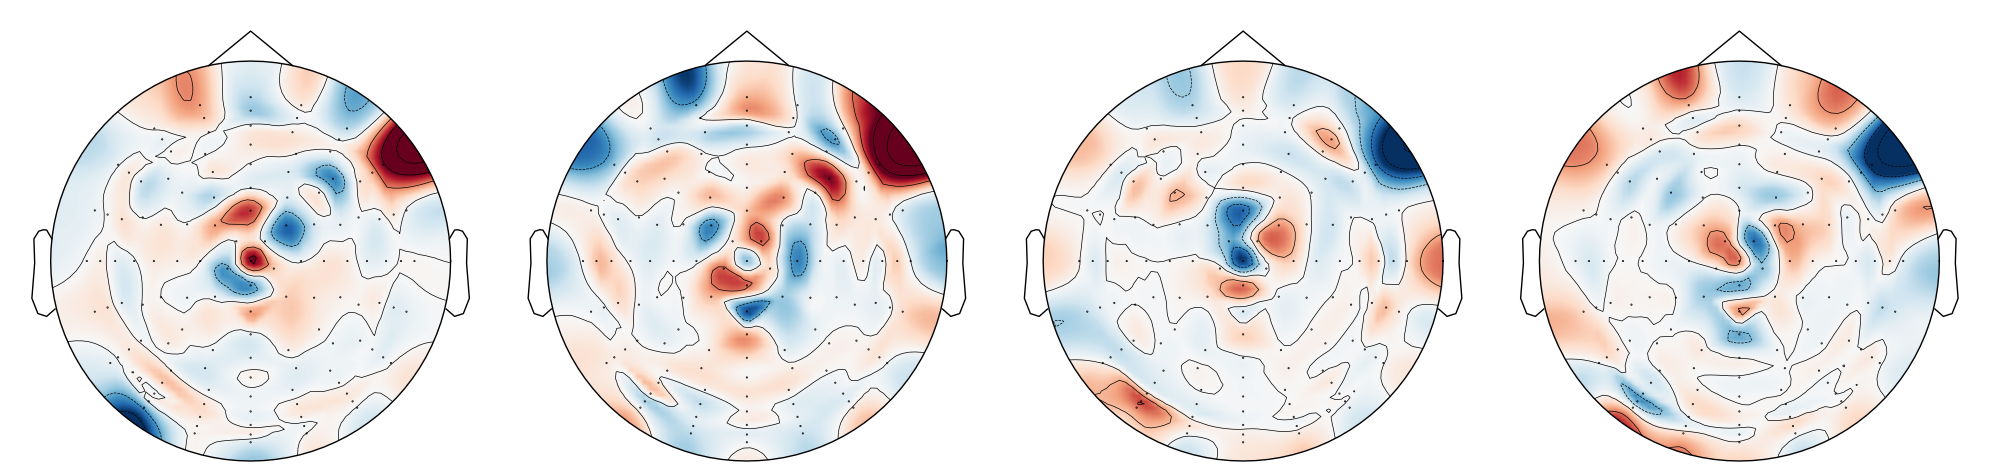

In [166]:
# Plot shap_values for a specific class

electrode_importance_0 = np.mean(shap_values[0], axis=(0, 2)).squeeze() # 0 = Arriba
electrode_importance_1 = np.mean(shap_values[1], axis=(0, 2)).squeeze() # 1 = Abajo
electrode_importance_2 = np.mean(shap_values[2], axis=(0, 2)).squeeze() # 2 = Derecha
electrode_importance_3 = np.mean(shap_values[3], axis=(0, 2)).squeeze() # 3 = Izquierda

assert electrode_importance_0.shape == (128,) # Ensure all arrays are 1D
assert electrode_importance_1.shape == (128,)
assert electrode_importance_2.shape == (128,)
assert electrode_importance_3.shape == (128,)

info = action_participants_inner[0].info # Again, get the info object from the first participant's inner speech epochs

# Plot the topomap for each class
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

mne.viz.plot_topomap(electrode_importance_0, info, axes=axes[0], show=False, ch_type='eeg', size=4)
mne.viz.plot_topomap(electrode_importance_1, info, axes=axes[1], show=False, ch_type='eeg', size=4)
mne.viz.plot_topomap(electrode_importance_2, info, axes=axes[2], show=False, ch_type='eeg', size=4)
mne.viz.plot_topomap(electrode_importance_3, info, axes=axes[3], show=False, ch_type='eeg', size=4)

plt.tight_layout()
plt.show()

In [ ]:
# Old code - balance multiclass-input-data ...

multi_balanced_X = []  
multi_balanced_y = []

modality_label = ['Arriba', 'Abajo', 'Derecha', 'Izquierda']

for participant_idx, participant in enumerate(action_participants_inner):
    X_participant = []
    y_participant = []
        
    for label in modality_label:
        data = participant[label]
        
        for trial_idx in range(len(data)):
            epoch_data = data[trial_idx].get_data()
            X_participant.append(epoch_data)
            label_index = modality_label.index(label)
            y_participant.append(label_index)

    X_participant = np.array(X_participant)
    y_participant = np.array(y_participant)

    class_before = Counter(y_participant)
    print(f'Participant {participant_idx}: {class_before}')

    if len(set(y_participant)) > 1:
        X_participant, y_participant = shuffle(X_participant, y_participant, random_state=123)
        
        X_2D = X_participant.reshape(-1, 128 * 641)
        
        # To make sure, that it balances all four classes
        sampling_strategy = {0: max(class_before.values()),
                             1: max(class_before.values()),
                             2: max(class_before.values()),
                             3: max(class_before.values())}

        oversample = RandomOverSampler(sampling_strategy=sampling_strategy)
        X_over, y_over = oversample.fit_resample(X_2D, y_participant)

        class_after = Counter(y_over)
        print(f'Participant {participant_idx} After: {class_after}')

        X_3D = X_over.reshape(-1, 128, 641)

        multi_balanced_X.append(X_3D)
        multi_balanced_y.append(y_over)

multi_X_overall = np.vstack(multi_balanced_X)
multi_y_overall = np.hstack(multi_balanced_y)
